## Imports

https://www.kaggle.com/mlg-ulb/creditcardfraud

In [59]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
plt.style.use("seaborn")

In [2]:
records = pd.read_csv('creditcard.csv', delimiter=',', header=0)
records.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


# Check if data is well-formed

## Distribution of fraudulent vs. good transactions
Very few fraudulent records

In [3]:
records.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

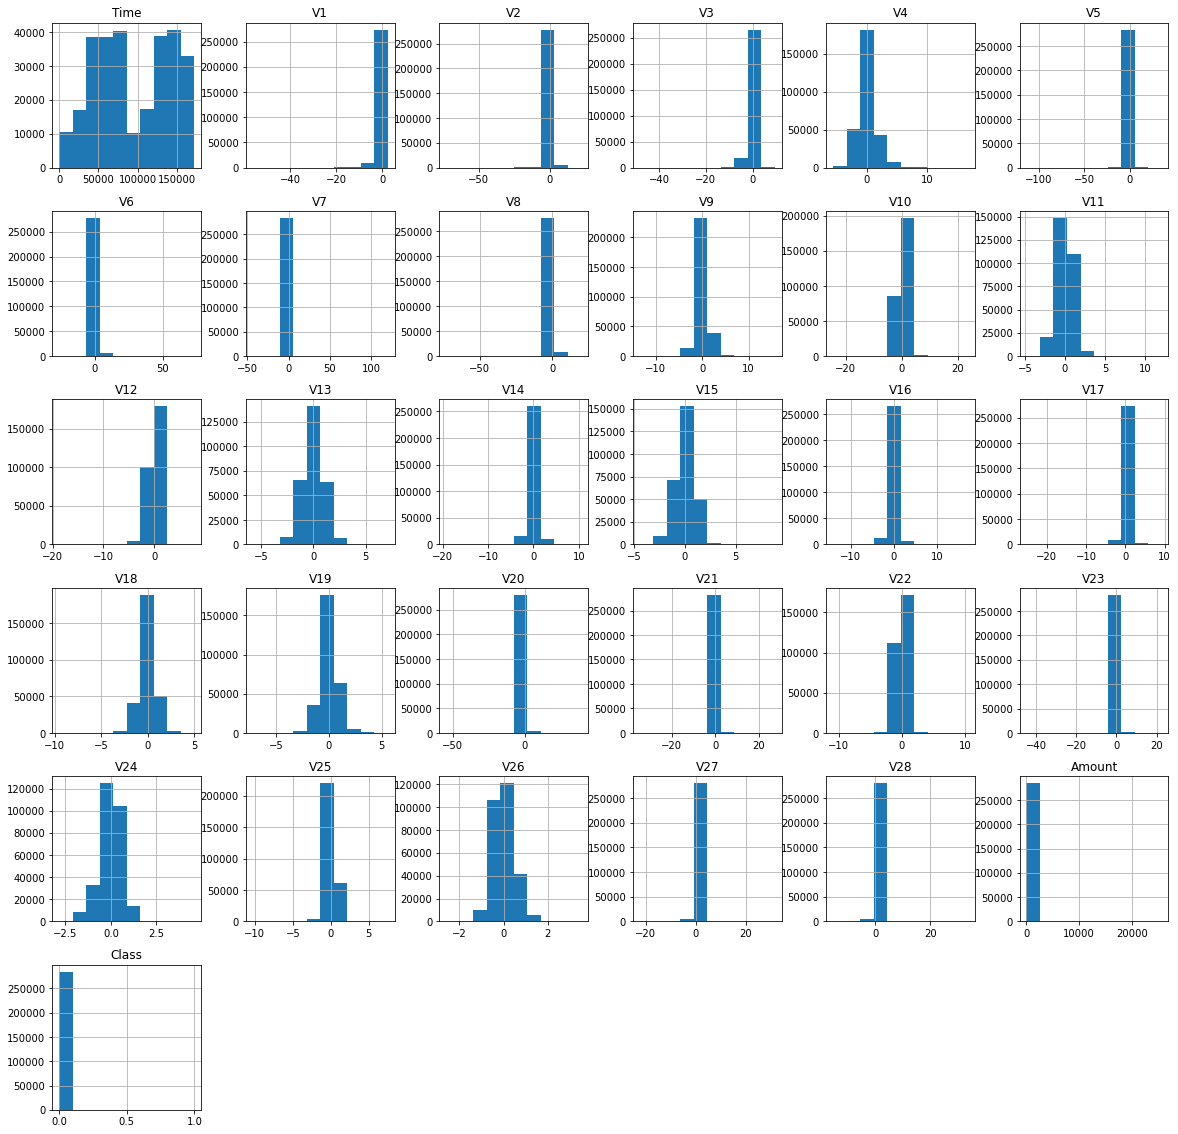

In [4]:
records.hist(figsize=(20,20));


## Normalize data

In [5]:
#Mean normalization
targets = records.pop('Class')
normalized_records=(records-records.mean())/records.std()
#normalized_records.hist(figsize=(20,20));

## Compare hists between classes

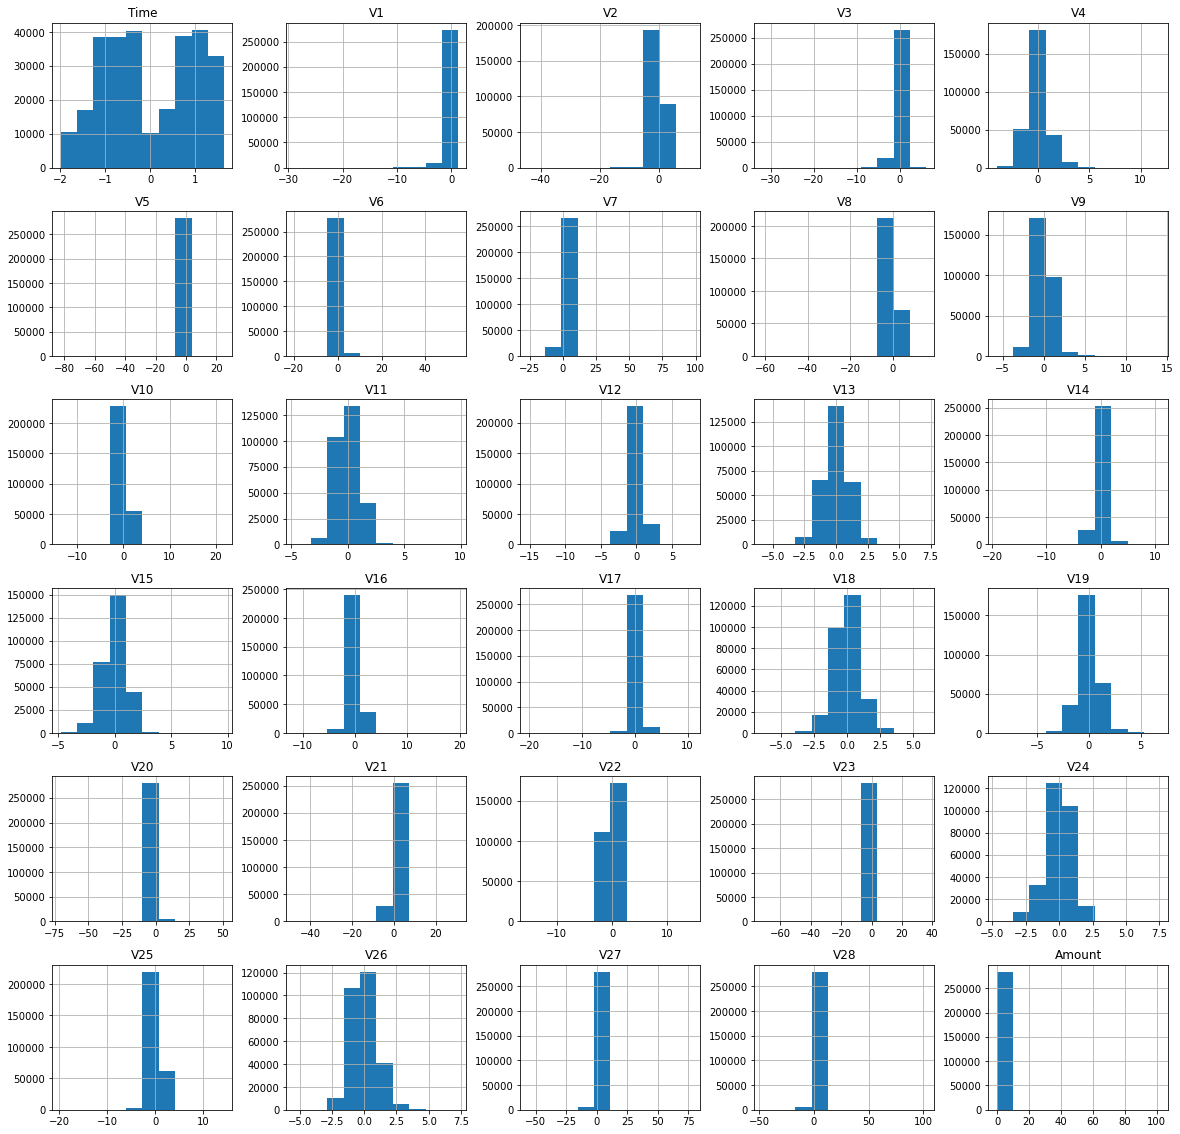

In [9]:
records0 = normalized_records[targets==0]
records1 = normalized_records[targets==1]
records0.hist(figsize=(20,20));

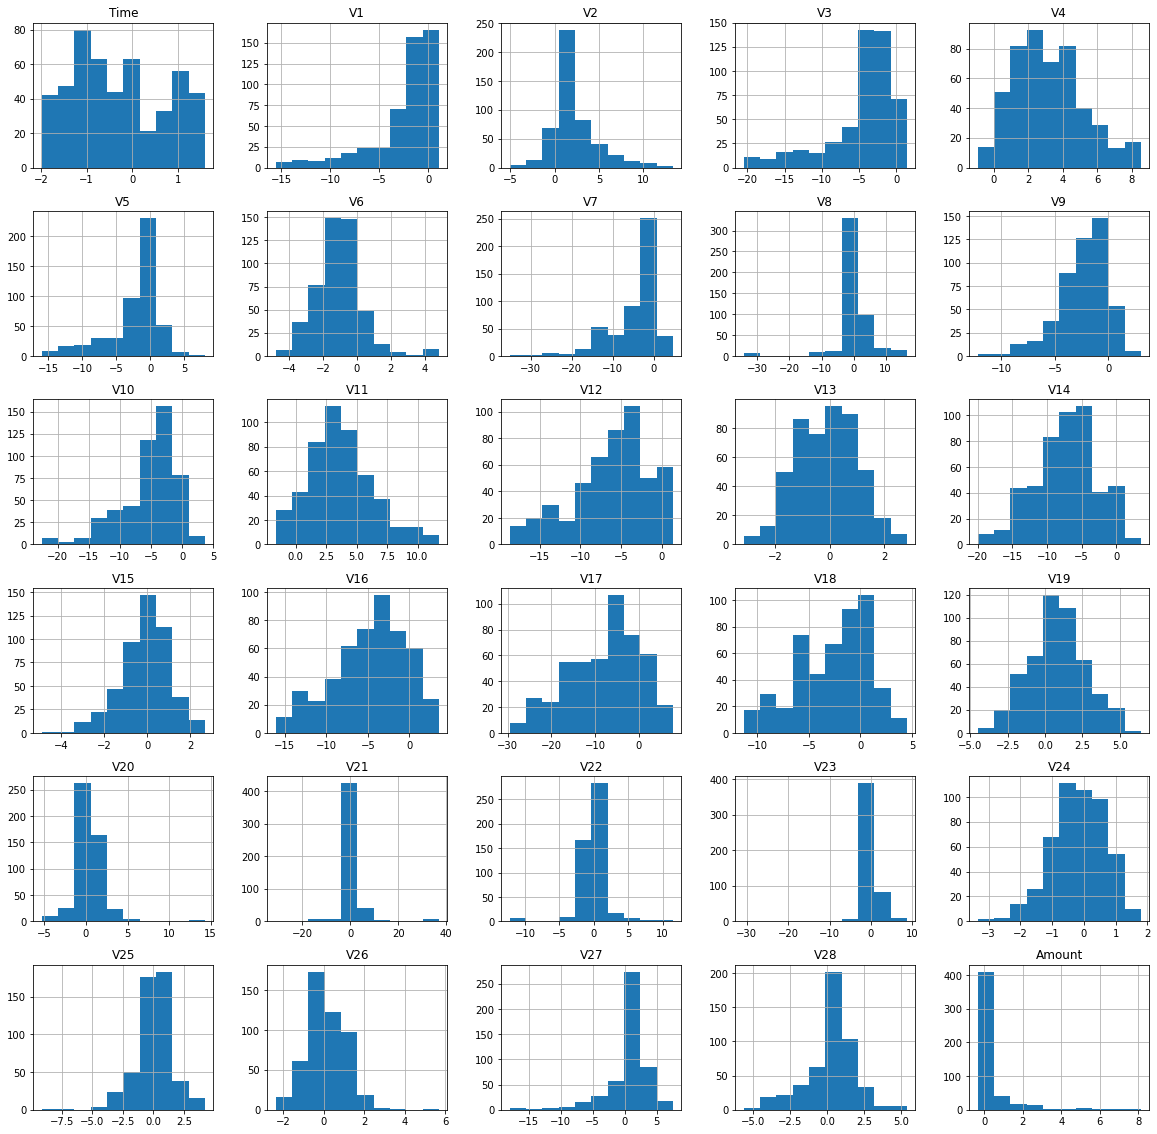

In [10]:
records1.hist(figsize=(20,20));

In [11]:
print("Differences between fraud and non-fraud:")
for i in records0.keys():
    print("Differences in",i)
    print("Median:", records0[i].median()-records1[i].median())
    print("Mean:", records0[i].mean()-records1[i].mean())
    print("Std:", records0[i].std()-records1[i].std())
    
    print()

Differences between fraud and non-fraud:
Differences in Time
Median: 0.19252172971223316
Mean: 0.2967350075315986
Std: -0.007398674870575661

Differences in V1
Median: 1.2061703137691455
Mean: 2.4405046304538205
Std: -2.4781146185470924

Differences in V2
Median: -1.6070883853499391
Mean: -2.198286258857717
Std: -1.6078579173914733

Differences in V3
Median: 3.4673686501116703
Mean: 4.64661415234859
Std: -3.727280862082994

Differences in V4
Median: -2.966060774701858
Mean: -3.2134966851943867
Std: -1.041046096449672

Differences in V5
Median: 1.0646680521499936
Mean: 2.2870389213706708
Std: -2.9092742802983906

Differences in V6
Median: 0.8643081611514458
Mean: 1.050953871019782
Std: -0.3964738063666099

Differences in V7
Median: 2.4861012371395548
Mean: 4.509252688613915
Std: -4.872679520684369

Differences in V8
Median: -0.5019178436083024
Mean: -0.4786050799310731
Std: -4.719331507786939

Differences in V9
Median: 1.9649929610563892
Mean: 2.3534625610834463
Std: -1.2848010599682733

In [21]:
top10 = ['V3', 'V4', 'V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18']
X = normalized_records[top10].to_numpy()
y = targets.to_numpy()

In [36]:
skf = StratifiedKFold(n_splits=10)
lrg = LogisticRegression()
accuracies = []
for train_index, test_index in tqdm(skf.split(X,y)):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    lrg.fit(X_train, y_train)
    accuracies.append(lrg.score(X_test, y_test))

print("Mean Logistic Regression Accuracy:", np.mean(accuracies))


10it [00:15,  1.53s/it]

Mean Logistic Regression Accuracy: 0.9991292340714824


In [56]:
def plot_roc_cur(fper, tper, label="", title="plot title"):
    plt.plot(fper, tper, label=label)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    
def create_roc_curve(preds, targets, label="", title=""):
    all_fpr, all_tpr = [], []
    fpr, tpr, thresholds = roc_curve(targets, preds)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_fpr = np.array(all_fpr)
    all_tpr = np.array(tpr)
    
    plot_roc_cur(all_fpr[0], all_tpr, label=label, title=title)

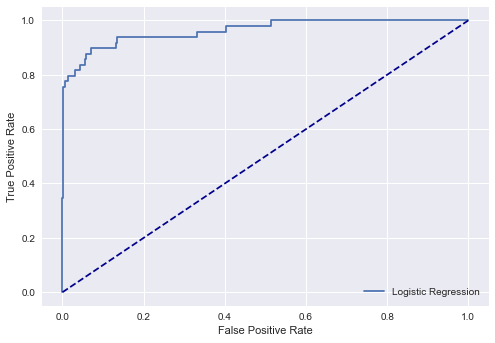

In [58]:
create_roc_curve(lrg.predict_proba(X_test)[:,1], y_test, label="Logistic Regression")

In [54]:
lrg.predict_proba(X_test)[:,1].shape

(28480,)